In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal


import DataProcessor

In [2]:
Gamma = 0.21  # Fracture energy (J/m^2)
E = 51e9      # Young's modulus (Pa)
nu = 0.25     # Poisson's ratio
C_f = 2404    # Rupture speed (m/s)
C_s = 2760    # Shear wave speed (m/s)
C_d = 4790    # Longitudinal wave speed (m/s)

In [3]:
filename = '../Data/p5993e.npz'

In [4]:
# data = np.load('/Users/hueyke/Downloads/p5993e.npz', allow_pickle=True)
data = np.load(filename, allow_pickle = True)
data = data["experiment"][()]
event = data['runs'][1]['events'][2]
exy6 = event['strain']['original']['raw'][6]


TIME_S = event['strain']['original']['time']

fs = len(TIME_S) / (np.max(TIME_S) - np.min(TIME_S))
print(f'Sampling rate: {fs:.1f}Hz')

DISTANCE = TIME_S * C_f * 1000 # mm


STRAIN = DataProcessor.voltage_to_strain(exy6)
STRESS = DataProcessor.shear_strain_to_stress(E, nu, STRAIN)
STRESS = STRESS - STRESS[0]
STRESS_MPA = STRESS / 10**6
STRESS_MPA *= -1

Sampling rate: 100000.2Hz


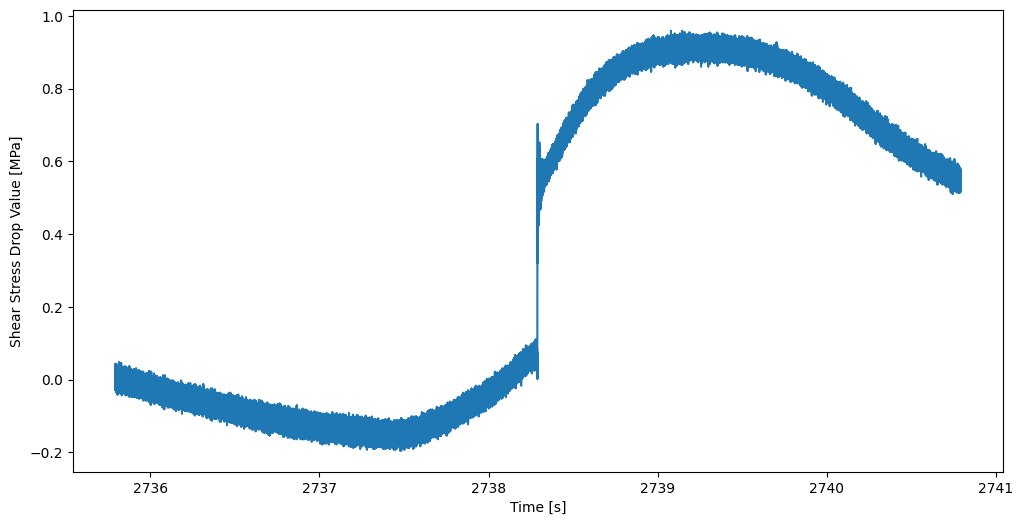

In [5]:
plt.figure(figsize = (12, 6))

plt.plot(TIME_S, STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
# plt.plot(event['strain']['original']['time'], eyy6 - eyy6[0], label=r'$\epsilon_{yy}$')
plt.savefig('../Plot/p5993_test1.pdf', dpi = 300)
plt.show()

In [6]:
cutoff = 100
filtered_data = DataProcessor.highpass_filter(STRESS_MPA, cutoff, fs)

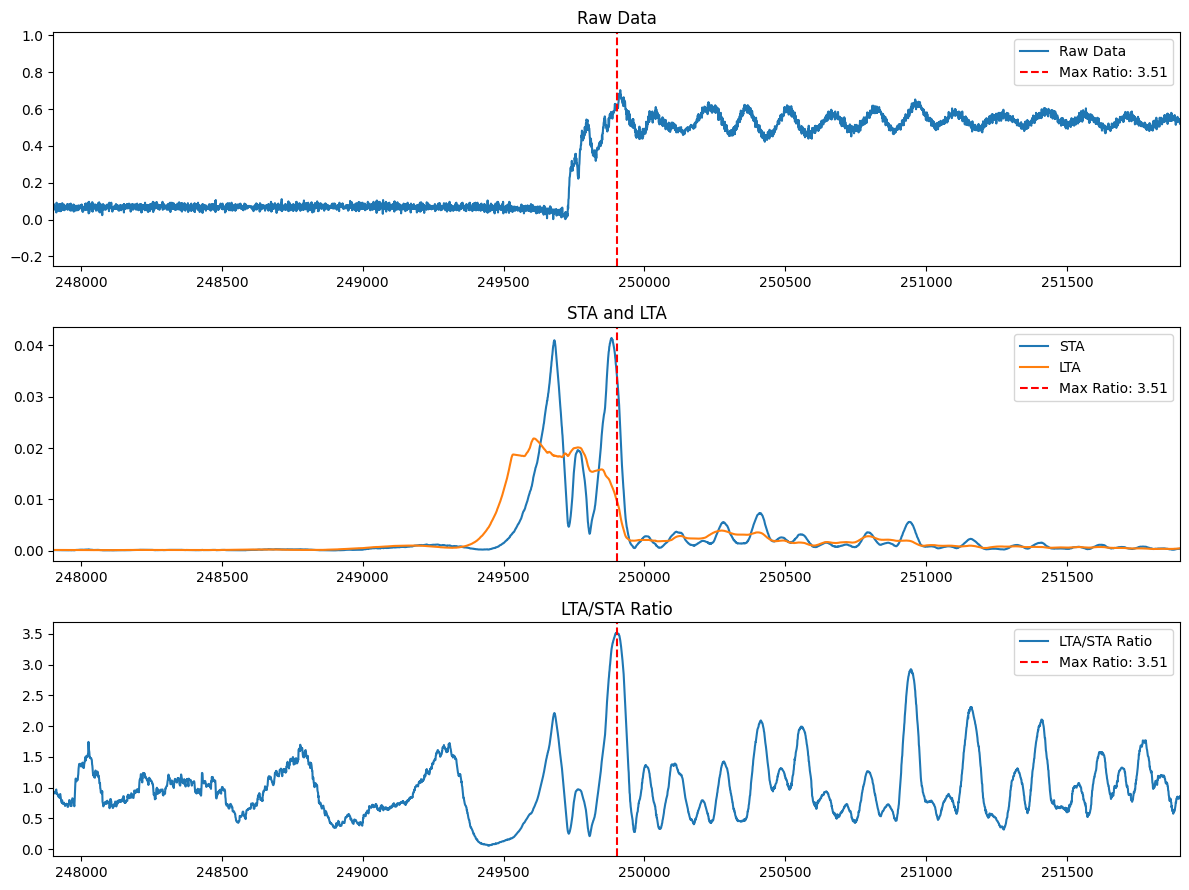

In [7]:
hspan = 2000


# STA, LTA window length
sta_window = 50   # STA window length
lta_window = 200  # LTA window length

# Calculate STA, LTA by convolution
sta = np.convolve(filtered_data**2, np.ones(sta_window)/sta_window, mode='valid')
lta = np.convolve(filtered_data**2, np.ones(lta_window)/lta_window, mode='valid')

# Matching STA and LTA data length
min_length = min(len(sta), len(lta))
sta = sta[:min_length]
lta = lta[:min_length]

# Calculate LTA/STA ratio
lta_sta_ratio = sta / lta

# Find peak and peak's index
max_ratio = np.max(lta_sta_ratio)
max_index = np.argmax(lta_sta_ratio)



plt.figure(figsize = (12, 9))

# Plot raw data (No filter)
plt.subplot(3, 1, 1)
plt.plot(STRESS_MPA, label = 'Raw Data')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('Raw Data')
plt.legend()

# Plot STA, LTA
plt.subplot(3, 1, 2)
plt.plot(sta, label = 'STA')
plt.plot(lta, label = 'LTA')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('STA and LTA')
plt.legend()

# Plot LTA/STA ratio
plt.subplot(3, 1, 3)
plt.plot(lta_sta_ratio, label='LTA/STA Ratio')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('LTA/STA Ratio')
plt.legend()

plt.tight_layout()
plt.savefig('../Plot/STA-LTA-5993-test.pdf')
plt.show()